[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/edwinRNDR/workshop-meme-viz/blob/master/notebooks/CLIP-feature-extractor.ipynb)


# CLIP prompt feature extractor

# Setup


## Install dependencies


In [3]:
!pip3 install transformers==4.23.1 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.2 rasterfairy-py3==1.0.5 umap-learn==0.5.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Download dataset

In [4]:
%%capture
!gdown 1lGoNJBM3cNEe935eO9MvFkQLIYnAppjj
!unzip scraped-memes.zip

# Feature extraction

## Configure prompts

In [5]:
prompts = ["a photograph of a man",
           "a photograph of a woman", 
           "a photograph of a group of people",
           "a photograph of a young man",
           "a photograph of an old man",
           "a photograph of a young woman",
           "a photograph of an old man2",
           "a dark background",
           "a bright background",
           "a photograph of a happy person",
           "a photograph of an angry person",
           "a photograph of a sad person",
           "a photograph of a drawing",
           "a photograph of an ugly person",
           "a photograph of a pretty person"
          ]

## Extract CLIP features

Use CLIP to extract features from images



In [6]:
import os
from transformers import CLIPProcessor, CLIPModel
import pandas as pd
from PIL import Image
from torch.cuda.amp import autocast
from tqdm import tqdm

device = "cuda"

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

model = model.to(device)
#processor = processor.to(device)

image_dir = "scraped-memes"
source_dirs = [f for f in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, f))]


prompt_logits_path = "prompt-logits.csv"

with autocast():
  with open(prompt_logits_path, "w") as f:
    print(",".join(prompts),file=f)
    for source_dir in tqdm(sorted(source_dirs)):
        image_path = os.path.join(image_dir, source_dir, "meme-image.jpg")

        if os.path.exists(image_path):
            image = Image.open(image_path)
            inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True).to(device)

            outputs = model(**inputs)

            logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
            logits = [str(logits_per_image[0][index].item()) for index, label in enumerate(prompts)]
            print(",".join(logits),file=f)
            

Downloading:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/862k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

 50%|█████     | 3143/6245 [02:31<02:09, 24.03it/s]/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
100%|██████████| 6245/6245 [05:32<00:00, 18.79it/s]


# Dimensionality reduction: 2 dimensions using tSNE

## Reduce features to two dimensions using tSNE

In [7]:
from sklearn.manifold import TSNE
import pandas as pd

prompt_logits_path = "prompt-logits.csv"
features = pd.read_csv(prompt_logits_path)
print(features.shape)

tsne = TSNE(n_components=2, perplexity=25, learning_rate=10)
embed = tsne.fit_transform(features)
embed = embed.reshape(features.shape[0],2)
pd.DataFrame(embed).to_csv("prompt-tsne.csv")



(6245, 15)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


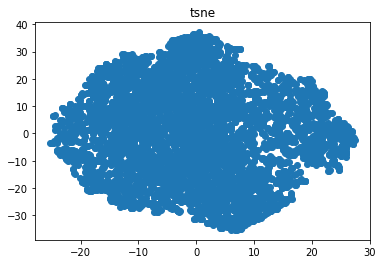

In [8]:
import matplotlib.pyplot as plt

plt.scatter(embed[:,0], embed[:,1])
plt.title("tsne")
plt.show()

## Apply grid layout to TSNE (optional)

This processes the `prompt-tsne.csv` file and produces `prompt-grid.csv`

In [10]:
import numpy as np
import rasterfairy

embed = pd.read_csv("prompt-tsne.csv").to_numpy()
embed = embed[:, 1:3]
print(embed.shape)
grid, (width, height) = rasterfairy.transformPointCloud2D(embed)

grid = np.asarray(grid)
grid = grid.reshape([-1, 2])

pd.DataFrame(grid).to_csv("prompt-grid.csv")

(6245, 2)
no good rectangle found for 6245 points, using incomplete square 79 * 80


# Dimensionality reduction: 3 dimensions using tSNE

In [23]:
from sklearn.manifold import TSNE
import pandas as pd

prompt_logits_path = "prompt-logits.csv"
features = pd.read_csv(prompt_logits_path)
print(features.shape)

tsne = TSNE(n_components=3, perplexity=25, learning_rate=10)
embed = tsne.fit_transform(features)
embed = embed.reshape(features.shape[0], 3)
pd.DataFrame(embed).to_csv("prompt-tsne-3d.csv")

(6245, 15)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


# Dimensionality reduction using spherical UMAP

Run this step if you need to map points on a sphere. Results are written into `prompt-umap-spherical.csv`




## Apply UMAP

Based on [UMAP spherical embeddings](https://umap-learn.readthedocs.io/en/latest/embedding_space.html#spherical-embeddings)

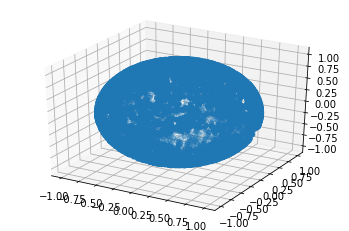

In [22]:
import umap
prompt_logits_path = "prompt-logits.csv"
features = pd.read_csv(prompt_logits_path)

sphere_mapper = umap.UMAP(output_metric='haversine', random_state=42).fit(features)

x = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
y = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
z = np.cos(sphere_mapper.embedding_[:, 0])
pd.DataFrame({"x":x, "y": y, "z": z}).to_csv("prompt-umap-spherical.csv")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
